# Movies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from pathlib import Path
from ruamel import yaml

from ipywidgets import interact

In [2]:
import lmfit
import h5py

from skimage.restoration import unwrap_phase

In [3]:
from lib_lt.tools import recursive_read_attrs

/home/carmelo/lense_thirring/lib_lt/tracker.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
%matplotlib notebook

In [5]:
root = Path('/home/carmelo/lense_thirring/code/bh3')

In [6]:
def plot2d(n0, p0):
    fig, (ax, ax_p) = plt.subplots(1, 2, figsize=(12, 6.5), sharex=True, sharey=True)
#     fig, (ax, ax_p) = plt.subplots(2, 1, figsize=(6, 12), sharex=True, sharey=True)
    fig.suptitle('/'.join(h5filename.parts[-4:]), y=1)

    kk = {'ticks': None, 'orientation': 'horizontal',
          'ticklocation': 'top'}  # read this from make_axes

    c1 = ax.imshow(np.rot90(n0), extent=extent)
    cax = ax.inset_axes([0, 1.06, 1, 0.04])
    plt.colorbar(c1, cax, **kk)
    
    time = ax.text(0, 1.2, '', transform=ax.transAxes)

    c2 = ax_p.imshow(np.rot90(p0), cmap='RdBu', extent=extent, vmin=-np.pi, vmax=np.pi)
    cax = ax_p.inset_axes([0, 1.06, 1, 0.04])
    plt.colorbar(c2, cax, **kk)

    R = abs(x.max())
    ax.set(xlabel='x', ylabel='y', xlim=(-R, R), ylim=(-R, R))
    ax_p.set(xlabel='x', ylabel='y', xlim=(-R, R), ylim=(-R, R))
    return fig, (ax, ax_p), c1, c2, time


In [7]:
root

PosixPath('/home/carmelo/lense_thirring/code/bh3')

In [22]:
!ls /home/carmelo/lense_thirring/code/bh3/run/


0000  0003  0006  0009	0012  0015  0018  0021	0024  0027  0030  0033
0001  0004  0007  0010	0013  0016  0019  0022	0025  0028  0031  0034
0002  0005  0008  0011	0014  0017  0020  0023	0026  0029  0032  0035


In [54]:
# h5filename = root / 'run/0034/bh_0000.h5'

# h5filename = root / 'run/0026/bh_0002.h5'   # (500, 10), ++
h5filename = root / 'run/0030/bh_0000.h5'  # (500, 10), --


In [55]:
conf = recursive_read_attrs(h5filename, 'configure')


# alpha = globs['alpha']
# nu = globs['nu']
# radius = globs['radius']
# Gamma = globs['Gamma']
# mu = 1



with h5py.File(h5filename, 'r') as f:
    try:
        g = f[f"realtime/1"]
#         g = f[f"imprint_pair/1"]
    except KeyError:
        g = f[f"1"]
    x = g['x'][:]
    y = g['y'][:]
    t = g['t'][:]
    psiI = g['psiI'][:]
    psiR = g['psiR'][:]
    
#     n0 = f['groundstate/1/psiI'][:]**2 + f['groundstate/1/psiR'][:]**2
    n0 = 0
    
L = len(x) // 2

r = x[L:]

# radial_slice = np.index_exp[L:0:-1, L]
radial_slice = np.index_exp[L, L:]

extent = (x.min(), x.max(), y.min(), y.max())

density = psiR**2 + psiI**2
N = density.sum(axis=(1, 2))
_phase = np.arctan2(psiI, psiR)

X, Y = np.meshgrid(x, y, indexing='ij')
R = np.hypot(X, Y)
phi = np.arctan2(Y, X)

In [56]:
total = 0
with h5py.File(h5filename, 'r') as f:
    for key in f.keys():
        try:
            et = f[f"{key}/log"].attrs['elapsed_time']
            print(f"{key}: elapsed_time = {et} s")
            total += et
        except KeyError:
            pass
        
m, s = divmod(total, 60)
h, m = divmod(m, 60)

print(f"Total runtime: {(h, m, s)}")

groundstate: elapsed_time = 1913.05 s
imprint_pair: elapsed_time = 183.31 s
realtime: elapsed_time = 33099.61 s
Total runtime: (9.0, 46.0, 35.970000000001164)


In [57]:
conf

{'build_dir': 'build',
 'dt': 1e-05,
 'h5filepath': '{sequence_index:04d}/bh_{run_number:04d}.h5',
 'run_dir': 'run',
 'sampling_dt': 0.125,
 'continue': {'init_filename': 'init_continue.h5',
  'output_filename': 'continue.h5',
  'runtime': 50},
 'excite': {'breakpoint_filename': 'excite_br.h5',
  'init_filename': 'groundstate.h5',
  'output_filename': 'excite.h5',
  'runtime': 0.2,
  'globals': {'Ue': 0.75, 'cx': 15, 'cy': 0, 'sx': 5, 'sy': 1}},
 'globals': {'Gamma': 500,
  'Lambda': 1,
  'U0': 10000,
  'alpha': 0.0065,
  'nu': 10,
  'radius': 50,
  'sigma': 3},
 'groundstate': {'output_filename': 'groundstate.h5', 'runtime': 15},
 'imprint_pair': {'breakpoint_filename': 'imprint_pair_br.h5',
  'fixed_x_index': 43,
  'fixed_y_index': 128,
  'init_filename': 'groundstate.h5',
  'output_filename': 'imprint_pair.h5',
  'runtime': 3,
  'globals': {'dv': 0.7, 'v1': -1, 'v2': -1, 'xv': 30}},
 'realtime': {'fixed_x_index': 43,
  'fixed_y_index': 128,
  'init_filename': 'imprint_pair_br.h5',


In [58]:
t.shape, t[-1]

((800,), 100.0000000261416)

<IPython.core.display.Javascript object>


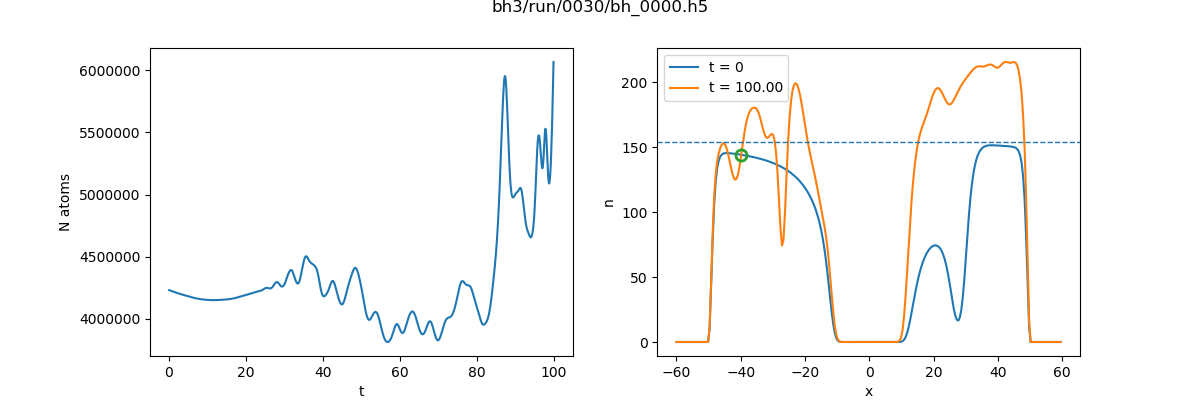

In [59]:
fig, (ax0, ax) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('/'.join(h5filename.parts[-4:]), y=1)

ax0.plot(t, N)
ax0.set(xlabel='t', ylabel='N atoms')

ix = -1
ax.plot(x, density[0, :, len(x)//2], label='t = 0')
ax.plot(x, density[ix, :, len(x)//2], label=f"t = {t[ix]:.2f}")

ax.plot(x[43], density[0, 43, 128], 'oC2', ms=8, mfc='none', mew=2)

ax.axhline(1 / conf['globals']['alpha'], ls='--', lw=1)

ax.set(xlabel='x', ylabel='n')
ax.legend()

<IPython.core.display.Javascript object>


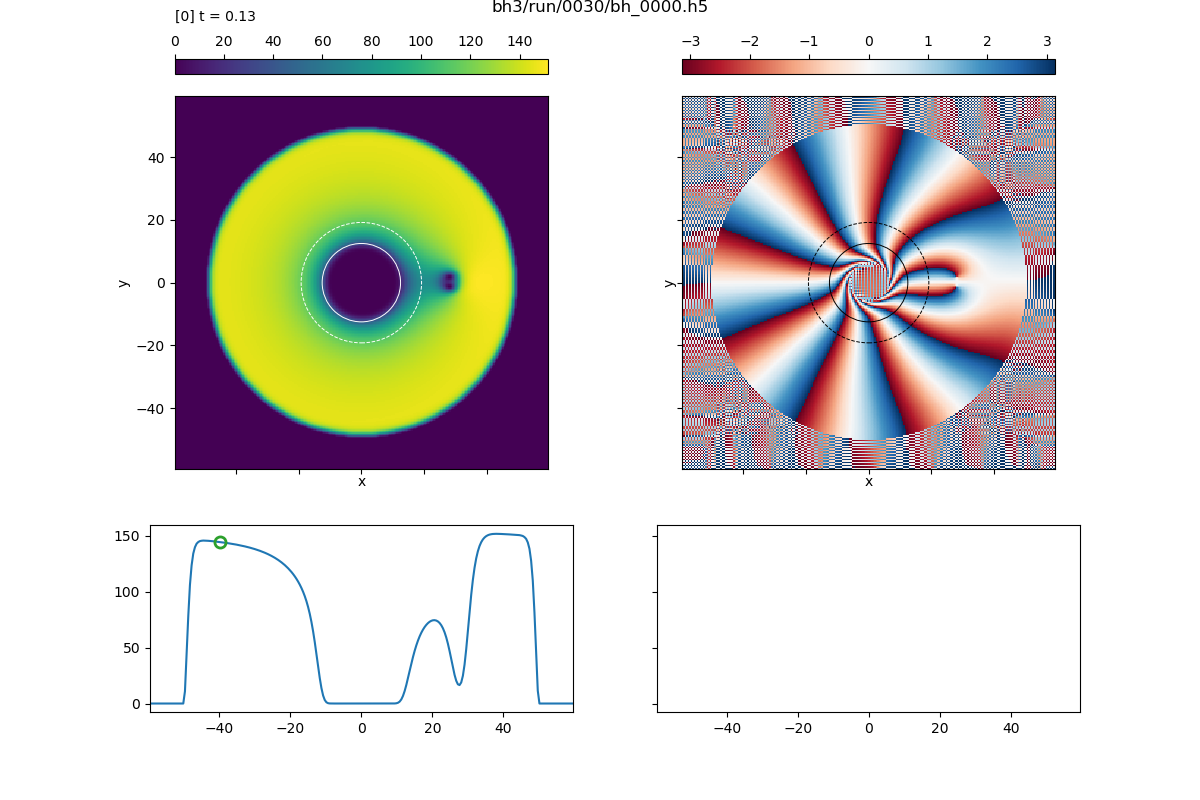

interactive(children=(IntSlider(value=399, description='ix', max=799), Output()), _dom_classes=('widget-intera…

In [60]:
fig, ((ax, ax_p), (ax_x, _)) = plt.subplots(2, 2, figsize=(12, 8), sharex='col', sharey='row', gridspec_kw=dict(height_ratios=[2, 1]))
#     fig, (ax, ax_p) = plt.subplots(2, 1, figsize=(6, 12), sharex=True, sharey=True)
fig.suptitle('/'.join(h5filename.parts[-4:]), y=1)

kk = {'ticks': None, 'orientation': 'horizontal',
      'ticklocation': 'top'}  # read this from make_axes

# n0 = density[0]
n0 = 0

c1 = ax.imshow(np.rot90(density[0] - n0), extent=extent)  # , cmap='RdBu_r', vmin=-10, vmax=10)
cax = ax.inset_axes([0, 1.06, 1, 0.04])
plt.colorbar(c1, cax, **kk)

time = ax.text(0, 1.2, '', transform=ax.transAxes)

c2 = ax_p.imshow(np.rot90(_phase[0]), cmap='RdBu', extent=extent, vmin=-np.pi, vmax=np.pi)
cax = ax_p.inset_axes([0, 1.06, 1, 0.04])
plt.colorbar(c2, cax, **kk)

R = abs(x.max())
ax.set(xlabel='x', ylabel='y', xlim=(-R, R), ylim=(-R, R))
ax_p.set(xlabel='x', ylabel='y', xlim=(-R, R), ylim=(-R, R))

l, = ax_x.plot(x, density[0, :, len(x)//2])
ax_x.plot(x[43], density[0, 43, 128], 'oC2', ms=8, mfc='none', mew=2)



rh, re = 12.5, 19.2

ax.add_patch(Ellipse((0, 0), 2*rh, 2*rh, fc='none', ec='w', lw=0.7))
ax.add_patch(Ellipse((0, 0), 2*re, 2*re, fc='none', ec='w', lw=0.7, ls='--'))

ax_p.add_patch(Ellipse((0, 0), 2*rh, 2*rh, fc='none', ec='k', lw=0.7))
ax_p.add_patch(Ellipse((0, 0), 2*re, 2*re, fc='none', ec='k', lw=0.7, ls='--'))


@interact(ix=(0, len(t) - 1))
def f(ix):
    c1.set_data(np.rot90(density[ix] - n0))
    c2.set_data(np.rot90(_phase[ix]))
    l.set_ydata(density[ix, :, len(x)//2])
    
    time.set_text(f"[{ix}] t = {t[ix]:.2f}")

    
# f(0)

In [15]:
np.argmin(abs(x + 44))

34

In [169]:
len(x)

256

In [170]:
density[0, 34, 128]

153.58964497675953

In [173]:
x[43]

-39.84375

In [130]:
10000  /60

166.66666666666666

In [15]:
166 / 60 * 5

13.833333333333332

In [17]:
print(len(t), t[-1])

800 99.99999999903768


In [18]:
def to_time(s):
    m, s = divmod(s, 60)
    h, m = divmod(m, 60)
    print(h, m, s)
    
to_time(60000)

16 40 0
